In [1]:
import os
import sys
import numpy as np
import pandas as pd
import igraph as ig
import networkx as nx
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from mpl_settings_v3 import *
from plot_auxiliary import *
from planar import create_proximity_graph
from fractal import get_box_count, get_cluster_densities
from auxiliary import getLinearReg, get_base_network_name, powerlaw, load_delta_data, read_data_file
from scipy.spatial import Delaunay

%matplotlib inline

net_type = 'DT'
param = 'param'

net_dir = os.path.join('..', 'networks', net_type)

In [2]:
print(mpl.__version__)
print(nx.__version__)

3.2.1
2.4


### Figura 0

Esquemática, distribución de betweenness, etc.

In [22]:
net_type = 'DT'
param = 'param'
attack = 'Btw'
networks_dir = os.path.join('..', 'networks')
N = 4096
min_seed = 0
max_seed = 100
all_btw_values = []
for seed in range(min_seed, max_seed):

    base_net_name, base_net_name_size = get_base_network_name(net_type, N, param)
    net_name = base_net_name_size + '_{:05d}'.format(seed)
    net_dir = os.path.join(networks_dir, net_type, base_net_name, base_net_name_size, net_name)
    attack_dir = os.path.join(net_dir, attack)
    btw_values = read_data_file(attack_dir, 'initial_centrality', reader='numpy')
    
    all_btw_values.append(btw_values)
    
all_btw_values = np.array(all_btw_values).flatten()

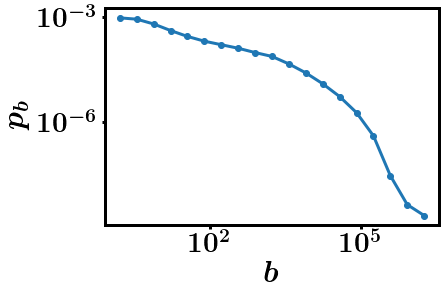

In [23]:
_all_btw_values = all_btw_values[all_btw_values>0]
bins = np.logspace(0, np.log10(_all_btw_values.max()+1), 20)
freq, bin_edges = np.histogram(_all_btw_values, bins=bins, density=True)
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2

fig, ax = plt.subplots()
ax.set_xlabel(r'$b$')
ax.set_ylabel(r'$p_b$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.plot(bin_centers, freq, '-o')

plt.show()

In [50]:
net_type = 'PDT'
param = 'param'
attack = 'Btw'
networks_dir = os.path.join('..', 'networks')
N = 4096
seed = 0

base_net_name, base_net_name_size = get_base_network_name(net_type, N, param)
net_name = base_net_name_size + '_{:05d}'.format(seed)
net_dir = os.path.join(networks_dir, net_type, base_net_name, base_net_name_size, net_name)

DT_base_net_name, DT_base_net_name_size = get_base_network_name('DT', N, param)
DT_net_name = DT_base_net_name_size + '_{:05d}'.format(seed)
DT_net_dir = os.path.join(networks_dir, 'DT', DT_base_net_name, DT_base_net_name_size, DT_net_name)

attack_dir = os.path.join(net_dir, attack)
initial_attack_dir = os.path.join(net_dir, 'Btw')

oi_list = read_data_file(attack_dir, 'oi_list', reader='numpyInt')

g = read_data_file(net_dir, net_name, reader='igraph')
position = read_data_file(DT_net_dir, 'position', reader='numpy')
btw_values = read_data_file(initial_attack_dir, 'initial_centrality', reader='numpy')
norm_btw_values = btw_values / btw_values.max()

In [51]:
#q = 1 - 0.0765380859375
#q = 1 - 0.026123046875 #BtwU
#q = 1 - 0.05108642578125 #BtwU_cutoff32
#q = 1 - 0.09539794921875 #BtwU_cutoff16
#q = 1 - 1/np.sqrt(N)
q = 1 - 0.151123046875 #PDT Btw
if attack == 'Btw':
    order = np.argsort(btw_values)
elif attack == 'BtwU':
    order = oi_list[::-1]
hi_mask = order[int(q*N):]
lo_mask = order[:int(q*N)]

color_weight = -np.log(btw_values[hi_mask])
#color_weight = -btw_values[hi_mask]
max_w = color_weight.max()
min_w = color_weight.min()
color_weight = color_weight / (max_w - min_w)
color_weight = color_weight - color_weight.min()

GRAY = np.array([128, 128, 128, 255]) / 255
#LIGHT_GRAY = np.array([64+128, 64+128, 64+128, 255]) / 255
LIGHT_GRAY = np.array([32+128, 32+128, 32+128, 255]) / 255
colormap = plt.get_cmap('YlOrBr')
node_colors = np.zeros((N, 4))
node_colors[lo_mask] = GRAY
node_colors[hi_mask] = colormap(color_weight)

node_sizes = np.ones(N)
node_sizes[hi_mask] = 15
node_sizes[lo_mask] = 2

M = g.ecount()
segments = []
edge_colors = np.zeros((M,4))
edge_lw = np.zeros(M)
es_hi_mask = []
es_lo_mask = []
n_edges = 0
for i, e in enumerate(g.es()):
    v, w = e.tuple
    seg = np.array([position[v], position[w]])
    if v in hi_mask and w in hi_mask:
        color = (node_colors[v] + node_colors[w]) / 2 ## TODO: corregir
        lw = 1
        es_hi_mask.append(i)
        n_edges += 1
    else:
        color = LIGHT_GRAY
        lw = 0.7
        es_lo_mask.append(i)
    segments.append(seg)
    edge_colors[i] = color
    edge_lw[i] = lw
    
print('n_nodes = ', hi_mask.size)
print('n_edges = ', n_edges)
segments = np.array(segments)
es_lo_mask = np.array(es_lo_mask, dtype='int')
es_hi_mask = np.array(es_hi_mask, dtype='int')

n_nodes =  619
n_edges =  731


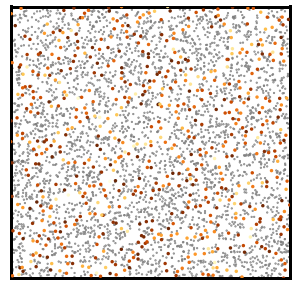

In [53]:
ncols = 1
nrows = 1
fig, ax = plt.subplots(figsize=(5*ncols, 5*nrows), ncols=ncols, nrows=nrows)
    
ax.set_xticks([])
ax.set_yticks([])
ax.margins(0)

ax.scatter(
    position[hi_mask][:,0], position[hi_mask][:,1], 
    marker='.', s=node_sizes[hi_mask], c=node_colors[hi_mask], zorder=4
)

ax.scatter(
    position[lo_mask][:,0], position[lo_mask][:,1], 
    marker='.', s=node_sizes[lo_mask], c=node_colors[lo_mask], zorder=1
)

line_collection = LineCollection(
    segments[es_hi_mask], linewidth=edge_lw[es_hi_mask], color=edge_colors[es_hi_mask], zorder=3
)
#ax.add_collection(line_collection)

line_collection = LineCollection(
    segments[es_lo_mask], linewidth=edge_lw[es_lo_mask], color=edge_colors[es_lo_mask], zorder=2
)
#ax.add_collection(line_collection)


fig_name = os.path.join(fig_dir, 'PRL_Fig0_a_{:.3f}'.format(q))
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')
plt.show()

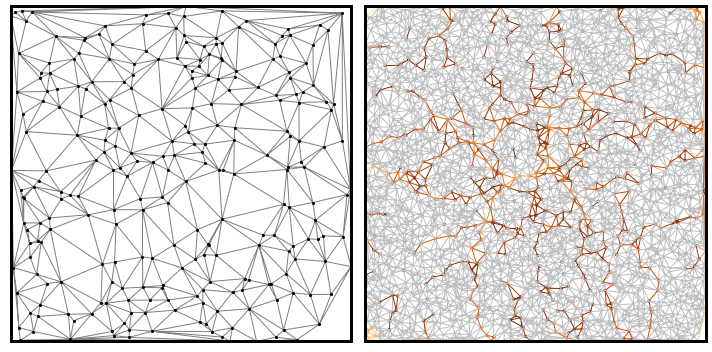

In [169]:
ncols = 2
nrows = 1
fig, axes = plt.subplots(figsize=(5*ncols, 5*nrows), ncols=ncols, nrows=nrows)

ax = axes[0]
L = 16
np.random.seed(10)
points = np.random.random((L*L, 2))
tri = Delaunay(points)

ax.margins(0)
ax.set_xticks([])
ax.set_yticks([])
ax.scatter(points[:,0], points[:,1], color='k', marker='.', s=10, zorder=10)
ax.triplot(points[:,0], points[:,1], tri.simplices, linewidth=1, color='0.5')

ax = axes[1]

if L == 128:
    ax.set_xticks([0, 32, 64, 96, 128])
    ax.set_yticks([0, 32, 64, 96, 128])
elif L == 256:
    ax.set_xticks([0, 64, 128, 192, 256])
    ax.set_yticks([0, 64, 128, 192, 256])
    
ax.set_xticks([])
ax.set_yticks([])
ax.margins(0)

ax.scatter(
    position[:,0], position[:,1], 
    marker='.', s=node_sizes, c=node_colors
)
ax.add_collection(line_collection)

plt.tight_layout()

fig_name = os.path.join(fig_dir, 'PRL_Fig0')
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')
plt.show()

### Figura 1

Caracterización de la transición de fase para ataque RB

[ 1024  2048  4096  8192 16384]


/home/nahuel/anaconda3/envs/networks3/lib/python3.6/site-packages/ipykernel_launcher.py:215: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


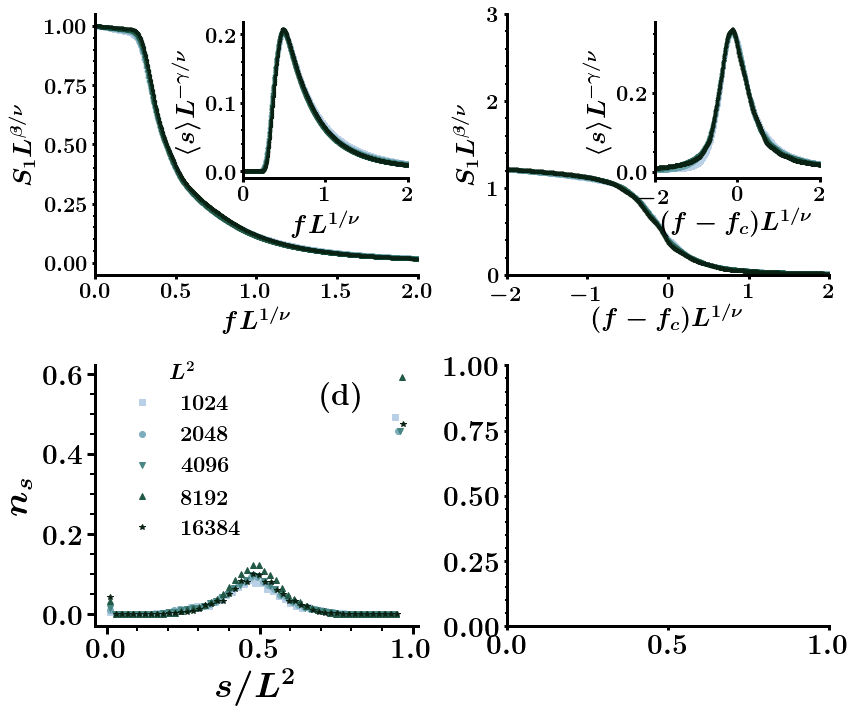

In [73]:
net_type = 'DT'
attack = 'BtwU'
sizes = [1024, 2048, 4096, 8192, 16384]
gcc = True

f_values_dict = {
    16384: ["0.02202", "0.02985", "0.02692"],
    8192: ["0.02633", "0.03650", "0.03198"],
    4096: ["0.03188", "0.04663", "0.03882"],
    2048: ["0.03875", "0.05469", "0.04834"],
    1024: ["0.04775", "0.06836", "0.05859"]
}

all_comp_sizes = {}
nseeds_values = {}

for N in sizes:
    f_value = f_values_dict[N][0]
    
    net_dir_name = '../networks/DT/DT_param'.format(param)
    base_net_name = 'DT_param_N{}'.format(N)
    base_net_dir_name = os.path.join(net_dir_name, base_net_name)
    if gcc:
        comp_sizes_file = 'comp_sizes_gcc_{}_f{}.txt'.format(attack, f_value)
        seeds_file = 'comp_sizes_gcc_{}_f{}_seeds.txt'.format(attack, f_value)
    else:
        comp_sizes_file = 'comp_sizes_{}_f{}.txt'.format(attack, f_value)
        seeds_file = 'comp_sizes_{}_f{}_seeds.txt'.format(attack, f_value)
    full_comp_sizes_file = os.path.join(base_net_dir_name, comp_sizes_file)
    full_seeds_file = os.path.join(base_net_dir_name, seeds_file)
    comp_sizes = np.loadtxt(full_comp_sizes_file, dtype=int)
    nseeds = len(np.loadtxt(full_seeds_file, dtype=int))

    nseeds_values[N] = nseeds
    all_comp_sizes[N] = comp_sizes

dfs = {}
for N in sizes:
    try:
        dfs[N] = load_dataframe(net_type, N, param, attack, min_nseeds=100)
    except FileNotFoundError:
        continue
        
N_values = np.sort(list(dfs.keys()))
L_values = np.sqrt(N_values)
print(N_values)
colormap = sns.cubehelix_palette(
    len(L_values), start=2, rot=0.3, light=0.8, dark=0.1
)

insets = []

ncols = 2
nrows = 2
fig, axes = plt.subplots(figsize=(6*ncols, 5*nrows), ncols=ncols, nrows=nrows)


#######################################

ax = axes[0,0]
ax.set_xlim(0, 2)
#ax.set_xticks([0, 1])
#ax.set_yticks([0, 0.2])
ax.set_ylabel(r'$S_1 L^{\beta/\nu}$', fontsize=26)
ax.set_xlabel(r'$f L^{1/\nu}$', fontsize=26)
ax.tick_params(axis='both', which='major', labelsize=22)

bbox_to_anchor = (.5, .42, .51, .6)
axins = inset_axes(ax, width="100%", height="100%",
        bbox_to_anchor=bbox_to_anchor,
        bbox_transform=ax.transAxes)
insets.append(axins)
axins.patch.set_alpha(0.)
axins.set_xlim(0, 2)
#axins.set_xticks([0, 1])
#axins.set_yticks([0, 0.2])
axins.set_ylabel(r'$\langle s\rangle L^{-\gamma/\nu}$', fontsize=26)
axins.set_xlabel(r'$f L^{1/\nu}$', fontsize=26)
#axins.xaxis.set_label_coords(0.5, -0.1)
#axins.yaxis.set_label_coords(-0.2, 0.5)
axins.tick_params(axis='both', which='major', labelsize=22)


for i, N in enumerate(N_values):
    
    df = dfs[N]
    L = np.sqrt(N)

    ax = axes[0,0]
    one_over_nu = 0.57
    nu = 1 / one_over_nu
    beta = 0
    beta_over_nu = beta / nu
    ax.plot(df.f*L**one_over_nu, df.Sgcc*N**(beta_over_nu), linestyle='', marker=markers[i], markersize=3,
        label=r'${{{}}}$'.format(N), color=colormap[i])
    
    ax = insets[0]
    one_over_nu = 0.57
    nu = 1 / one_over_nu
    gamma_over_nu = 2.05
    gamma = gamma_over_nu * nu
    ax.plot(
        df.f*L**one_over_nu, df.meanS*L**(-gamma_over_nu), linestyle='', 
        marker=markers[i], markersize=3, color=colormap[i]
    )
    

    

####################################

ax = axes[1,0]
ax.tick_params(which='minor', length=5)
ax.tick_params(which='major', length=8)
ax.set_xlabel(r'$s/L^2$', fontsize=36)
ax.set_ylabel(r'$n_s$', fontsize=36)    
ax.text(0.7, 0.85, letters[3], transform=ax.transAxes, fontsize=30)

for i, N in enumerate(sizes):

    nseeds = nseeds_values[N]
    comp_sizes = all_comp_sizes[N]
    nbins = 50   
    hist, bin_edges = np.histogram(comp_sizes, bins=nbins, density=False)
    
    X = (bin_edges[1:] + bin_edges[:-1]) / 2
    Y = hist

    X = X / N
    Y = Y / nseeds
    ax.plot(
        X, Y, marker=markers[i], linestyle='', label=r'${{{}}}$'.format(N), color=colormap[i]
    )

legend = ax.legend(loc=(0.05, 0.3), fontsize=22, frameon=False)
legend.set_title(r'$L^2$', prop={'size':22})



#####################################################

attack = 'BtwU_cutoff3'

dfs = {}
for N in sizes:
    try:
        dfs[N] = load_dataframe(net_type, N, param, attack, min_nseeds=100)
    except FileNotFoundError:
        continue
        
N_values = np.sort(list(dfs.keys()))
L_values = np.sqrt(N_values)

colormap = sns.cubehelix_palette(
    len(L_values), start=2, rot=0.3, light=0.8, dark=0.1
)



#######################################

ax = axes[0,1]
ax.set_xlim(-2, 2)
ax.set_ylim(0, 3)
#ax.set_xticks([0, 1])
#ax.set_yticks([0, 0.2])
ax.set_ylabel(r'$S_1 L^{\beta/\nu}$', fontsize=26)
ax.set_xlabel(r'$(f-f_c)  L^{1/\nu}$', fontsize=26)
ax.tick_params(axis='both', which='major', labelsize=22)

bbox_to_anchor = (.5, .42, .51, .6)
axins = inset_axes(ax, width="100%", height="100%",
        bbox_to_anchor=bbox_to_anchor,
        bbox_transform=ax.transAxes)
insets.append(axins)
axins.patch.set_alpha(0.)
axins.set_xlim(-2, 2)
#axins.set_xticks([0, 1])
#axins.set_yticks([0, 0.2])
axins.set_ylabel(r'$\langle s\rangle L^{-\gamma/\nu}$', fontsize=26)
axins.set_xlabel(r'$(f-f_c) L^{1/\nu}$', fontsize=26)
#axins.xaxis.set_label_coords(0.5, -0.1)
#axins.yaxis.set_label_coords(-0.2, 0.5)
axins.tick_params(axis='both', which='major', labelsize=22)

fc = 0.34 # l = 2
fc = 0.28684 # l = 3
for i, N in enumerate(N_values):
    
    df = dfs[N]
    L = np.sqrt(N)

    ax = axes[0,1]
    one_over_nu = 0.75
    nu = 1 / one_over_nu
    beta_over_nu = 0.18 # l = 2
    beta_over_nu = 0.05 # l = 3
    ax.plot(
        (df.f-fc)*L**one_over_nu, df.Sgcc*N**(beta_over_nu), linestyle='',
        marker=markers[i], markersize=3,
        label=r'${{{}}}$'.format(N), color=colormap[i])
    
    ax = insets[1]
    one_over_nu = 0.75
    nu = 1 / one_over_nu
    gamma_over_nu = 1.56 # l = 2
    gamma_over_nu = 1.54 # l = 3
    gamma = gamma_over_nu * nu
    ax.plot(
        (df.f-fc)*L**one_over_nu, df.meanS*L**(-gamma_over_nu), linestyle='', 
        marker=markers[i], markersize=3, color=colormap[i]
    )

sns.despine()
plt.tight_layout()
fig_name = os.path.join(fig_dir, 'PRL_Fig1_v2')
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')
plt.show()

[ 1024  2048  4096  8192 16384]


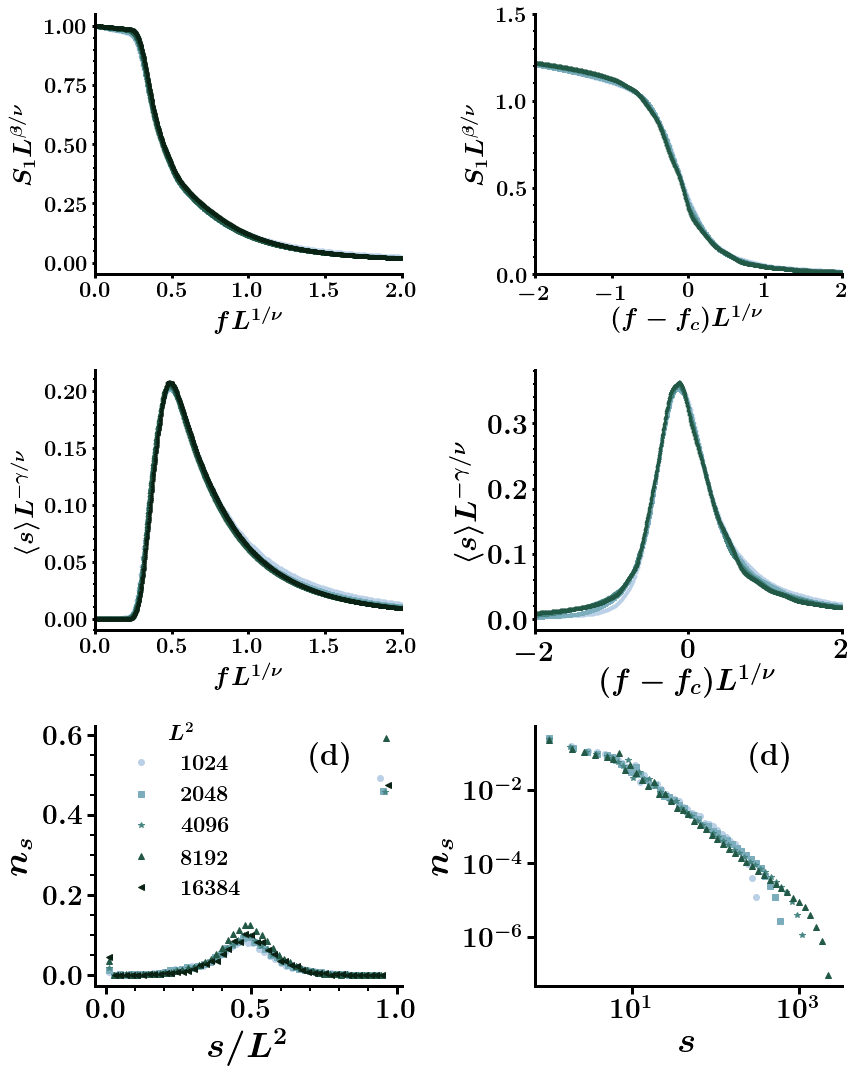

In [104]:
net_type = 'DT'
attack = 'BtwU'
sizes = [1024, 2048, 4096, 8192, 16384]
gcc = True

f_values_dict = {
    16384: ["0.02202", "0.02985", "0.02692"],
    8192: ["0.02633", "0.03650", "0.03198"],
    4096: ["0.03188", "0.04663", "0.03882"],
    2048: ["0.03875", "0.05469", "0.04834"],
    1024: ["0.04775", "0.06836", "0.05859"]
}

all_comp_sizes = {}
nseeds_values = {}

for N in sizes:
    f_value = f_values_dict[N][0]
    
    net_dir_name = '../networks/DT/DT_param'.format(param)
    base_net_name = 'DT_param_N{}'.format(N)
    base_net_dir_name = os.path.join(net_dir_name, base_net_name)
    if gcc:
        comp_sizes_file = 'comp_sizes_gcc_{}_f{}.txt'.format(attack, f_value)
        seeds_file = 'comp_sizes_gcc_{}_f{}_seeds.txt'.format(attack, f_value)
    else:
        comp_sizes_file = 'comp_sizes_{}_f{}.txt'.format(attack, f_value)
        seeds_file = 'comp_sizes_{}_f{}_seeds.txt'.format(attack, f_value)
    full_comp_sizes_file = os.path.join(base_net_dir_name, comp_sizes_file)
    full_seeds_file = os.path.join(base_net_dir_name, seeds_file)
    comp_sizes = np.loadtxt(full_comp_sizes_file, dtype=int)
    nseeds = len(np.loadtxt(full_seeds_file, dtype=int))

    nseeds_values[N] = nseeds
    all_comp_sizes[N] = comp_sizes

dfs = {}
for N in sizes:
    try:
        dfs[N] = load_dataframe(net_type, N, param, attack, min_nseeds=100)
    except FileNotFoundError:
        continue
        
N_values = np.sort(list(dfs.keys()))
L_values = np.sqrt(N_values)
print(N_values)
colormap = sns.cubehelix_palette(
    len(L_values), start=2, rot=0.3, light=0.8, dark=0.1
)

insets = []

ncols = 2
nrows = 3
fig, axes = plt.subplots(figsize=(6*ncols, 5*nrows), ncols=ncols, nrows=nrows)


#######################################

ax = axes[0,0]
ax.set_xlim(0, 2)
ax.set_ylabel(r'$S_1 L^{\beta/\nu}$', fontsize=26)
ax.set_xlabel(r'$f L^{1/\nu}$', fontsize=26)
ax.tick_params(axis='both', which='major', labelsize=22)

ax = axes[1,0]
ax.set_xlim(0, 2)
ax.set_ylabel(r'$\langle s\rangle L^{-\gamma/\nu}$', fontsize=26)
ax.set_xlabel(r'$f L^{1/\nu}$', fontsize=26)
ax.tick_params(axis='both', which='major', labelsize=22)


for i, N in enumerate(N_values):
    
    df = dfs[N]
    L = np.sqrt(N)

    ax = axes[0,0]
    one_over_nu = 0.57
    nu = 1 / one_over_nu
    beta = 0
    beta_over_nu = beta / nu
    ax.plot(df.f*L**one_over_nu, df.Sgcc*N**(beta_over_nu), linestyle='', marker=markers[i], markersize=3,
        label=r'${{{}}}$'.format(N), color=colormap[i])
    
    ax = axes[1,0]
    one_over_nu = 0.57
    nu = 1 / one_over_nu
    gamma_over_nu = 2.05
    gamma = gamma_over_nu * nu
    ax.plot(
        df.f*L**one_over_nu, df.meanS*L**(-gamma_over_nu), linestyle='', 
        marker=markers[i], markersize=3, color=colormap[i]
    )


####################################

ax = axes[2,0]
ax.tick_params(which='minor', length=5)
ax.tick_params(which='major', length=8)
ax.set_xlabel(r'$s/L^2$', fontsize=36)
ax.set_ylabel(r'$n_s$', fontsize=36)    
ax.text(0.7, 0.85, letters[3], transform=ax.transAxes, fontsize=30)

for i, N in enumerate(sizes):

    nseeds = nseeds_values[N]
    comp_sizes = all_comp_sizes[N]
    nbins = 50   
    hist, bin_edges = np.histogram(comp_sizes, bins=nbins, density=False)
    
    X = (bin_edges[1:] + bin_edges[:-1]) / 2
    Y = hist

    X = X / N
    Y = Y / nseeds
    ax.plot(
        X, Y, marker=markers[i], linestyle='', label=r'${{{}}}$'.format(N), color=colormap[i]
    )

legend = ax.legend(loc=(0.05, 0.3), fontsize=22, frameon=False)
legend.set_title(r'$L^2$', prop={'size':22})


#####################################################
#####################################################

attack = 'BtwU_cutoff3'
sizes = [1024, 2048, 4096, 8192]
gcc = False

f_values_dict = {
    8192: ["_", "0.28259", "_"],
    4096: ["_", "0.28101", "_"],
    2048: ["_", "0.27881", "_"],
    1024: ["_", "0.27734", "_"]
}

all_comp_sizes = {}
nseeds_values = {}

for N in sizes:
    f_value = f_values_dict[N][1]
    
    net_dir_name = '../networks/DT/DT_param'.format(param)
    base_net_name = 'DT_param_N{}'.format(N)
    base_net_dir_name = os.path.join(net_dir_name, base_net_name)
    if gcc:
        comp_sizes_file = 'comp_sizes_gcc_{}_f{}.txt'.format(attack, f_value)
        seeds_file = 'comp_sizes_gcc_{}_f{}_seeds.txt'.format(attack, f_value)
    else:
        comp_sizes_file = 'comp_sizes_{}_f{}.txt'.format(attack, f_value)
        seeds_file = 'comp_sizes_{}_f{}_seeds.txt'.format(attack, f_value)
    full_comp_sizes_file = os.path.join(base_net_dir_name, comp_sizes_file)
    full_seeds_file = os.path.join(base_net_dir_name, seeds_file)
    comp_sizes = np.loadtxt(full_comp_sizes_file, dtype=int)
    nseeds = len(np.loadtxt(full_seeds_file, dtype=int))

    nseeds_values[N] = nseeds
    all_comp_sizes[N] = comp_sizes

dfs = {}
for N in sizes:
    try:
        dfs[N] = load_dataframe(net_type, N, param, attack, min_nseeds=100)
    except FileNotFoundError:
        continue
        
N_values = np.sort(list(dfs.keys()))
L_values = np.sqrt(N_values)

#######################################

ax = axes[0,1]
ax.set_xlim(-2, 2)
ax.set_ylim(0, 1.5)
#ax.set_xticks([0, 1])
#ax.set_yticks([0, 0.2])
ax.set_ylabel(r'$S_1 L^{\beta/\nu}$', fontsize=26)
ax.set_xlabel(r'$(f-f_c)  L^{1/\nu}$', fontsize=26)
ax.tick_params(axis='both', which='major', labelsize=22)

ax = axes[1,1]
ax.set_xlim(-2, 2)
ax.set_ylabel(r'$\langle s\rangle L^{-\gamma/\nu}$')
ax.set_xlabel(r'$(f-f_c) L^{1/\nu}$')


fc = 0.34 # l = 2
fc = 0.28684 # l = 3
for i, N in enumerate(N_values):
    
    df = dfs[N]
    L = np.sqrt(N)

    ax = axes[0,1]
    one_over_nu = 0.75
    nu = 1 / one_over_nu
    beta_over_nu = 0.18 # l = 2
    beta_over_nu = 0.05 # l = 3
    ax.plot(
        (df.f-fc)*L**one_over_nu, df.Sgcc*N**(beta_over_nu), linestyle='',
        marker=markers[i], markersize=3,
        label=r'${{{}}}$'.format(N), color=colormap[i])
    
    ax = axes[1,1]
    one_over_nu = 0.75
    nu = 1 / one_over_nu
    gamma_over_nu = 1.56 # l = 2
    gamma_over_nu = 1.54 # l = 3
    gamma = gamma_over_nu * nu
    ax.plot(
        (df.f-fc)*L**one_over_nu, df.meanS*L**(-gamma_over_nu), linestyle='', 
        marker=markers[i], markersize=3, color=colormap[i]
    )


####################################

ax = axes[2,1]
ax.set_xscale('log')
ax.set_yscale('log')
ax.tick_params(which='minor', length=5)
ax.tick_params(which='major', length=8)
ax.set_xlabel(r'$s$', fontsize=36)
ax.set_ylabel(r'$n_s$', fontsize=36)    
ax.text(0.7, 0.85, letters[3], transform=ax.transAxes, fontsize=30)

for i, N in enumerate(sizes):

    nseeds = nseeds_values[N]
    comp_sizes = all_comp_sizes[N]
    nbins = 50   
    X, Y = get_histo(comp_sizes, nbins=nbins)
    
    ax.plot(
        X, Y, marker=markers[i], linestyle='', color=colormap[i]
    )
    
sns.despine()
plt.tight_layout()
fig_name = os.path.join(fig_dir, 'PRL_Fig1_v2')
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')
plt.show()

/home/nahuel/anaconda3/envs/networks3/lib/python3.6/site-packages/ipykernel_launcher.py:329: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


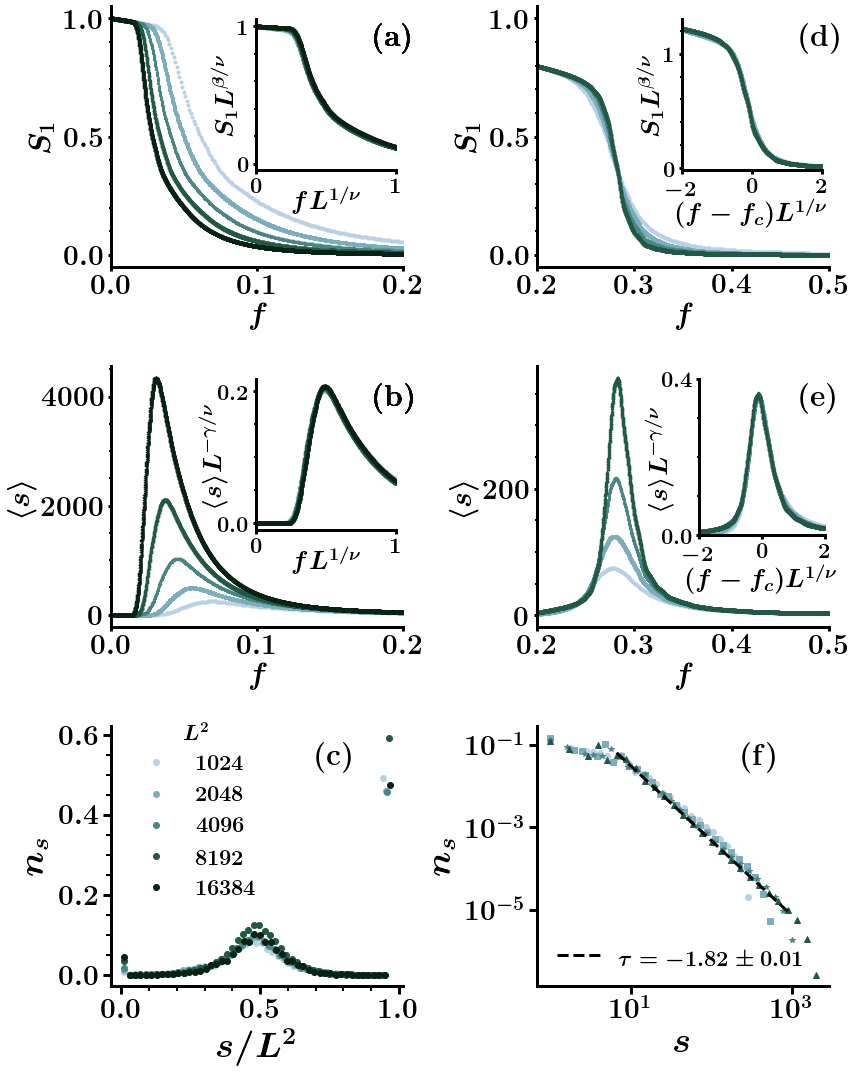

In [117]:
attack = 'BtwU'
sizes = [1024, 2048, 4096, 8192, 16384]
gcc = True

f_values_dict = {
    16384: ["0.02202", "0.02985", "0.02692"],
    8192: ["0.02633", "0.03650", "0.03198"],
    4096: ["0.03188", "0.04663", "0.03882"],
    2048: ["0.03875", "0.05469", "0.04834"],
    1024: ["0.04775", "0.06836", "0.05859"]
}

all_comp_sizes = {}
nseeds_values = {}

for N in sizes:
    f_value = f_values_dict[N][0]
    
    net_dir_name = '../networks/DT/DT_param'.format(param)
    base_net_name = 'DT_param_N{}'.format(N)
    base_net_dir_name = os.path.join(net_dir_name, base_net_name)
    if gcc:
        comp_sizes_file = 'comp_sizes_gcc_{}_f{}.txt'.format(attack, f_value)
        seeds_file = 'comp_sizes_gcc_{}_f{}_seeds.txt'.format(attack, f_value)
    else:
        comp_sizes_file = 'comp_sizes_{}_f{}.txt'.format(attack, f_value)
        seeds_file = 'comp_sizes_{}_f{}_seeds.txt'.format(attack, f_value)
    full_comp_sizes_file = os.path.join(base_net_dir_name, comp_sizes_file)
    full_seeds_file = os.path.join(base_net_dir_name, seeds_file)
    comp_sizes = np.loadtxt(full_comp_sizes_file, dtype=int)
    nseeds = len(np.loadtxt(full_seeds_file, dtype=int))

    nseeds_values[N] = nseeds
    all_comp_sizes[N] = comp_sizes

dfs = {}
for N in sizes:
    try:
        dfs[N] = load_dataframe(net_type, N, param, attack, min_nseeds=100)
    except FileNotFoundError:
        continue
        
N_values = np.sort(list(dfs.keys()))
L_values = np.sqrt(N_values)

colormap = sns.cubehelix_palette(
    len(L_values), start=2, rot=0.3, light=0.8, dark=0.1
)

insets = []

ncols = 2
nrows = 3
fig, axes = plt.subplots(figsize=(6*ncols, 5*nrows), ncols=ncols, nrows=nrows)
    
ax = axes[0,0]
ax.set_xlim(0, 0.2)
ax.set_xlabel(r'$f$')
ax.set_ylabel(r'$S_1$')


bbox_to_anchor = (.54, .42, .48, .58)
axins = inset_axes(ax, width="100%", height="100%",
        bbox_to_anchor=bbox_to_anchor,
        bbox_transform=ax.transAxes)
insets.append(axins)
axins.patch.set_alpha(0.)
axins.set_xlim(0, 1)
axins.set_xticks([0, 1])
axins.set_yticks([0, 1])
axins.set_ylabel(r'$S_1 L^{\beta/\nu}$', fontsize=26)
axins.set_xlabel(r'$f L^{1/\nu}$', fontsize=26)
axins.xaxis.set_label_coords(0.5, -0.1)
axins.yaxis.set_label_coords(-0.1, 0.5)
axins.tick_params(axis='both', which='major', labelsize=22)

#######################################

ax = axes[1,0]
ax.set_xlim(0, 0.2)
ax.set_xlabel(r'$f$')
ax.set_ylabel(r'$\langle s\rangle$')


bbox_to_anchor = (.54, .42, .48, .58)
axins = inset_axes(ax, width="100%", height="100%",
        bbox_to_anchor=bbox_to_anchor,
        bbox_transform=ax.transAxes)
insets.append(axins)
axins.patch.set_alpha(0.)
axins.set_xlim(0, 1)
axins.set_xticks([0, 1])
axins.set_yticks([0, 0.2])
axins.set_ylabel(r'$\langle s\rangle L^{-\gamma/\nu}$', fontsize=26)
axins.set_xlabel(r'$f L^{1/\nu}$', fontsize=26)
axins.xaxis.set_label_coords(0.5, -0.1)
axins.yaxis.set_label_coords(-0.2, 0.5)
axins.tick_params(axis='both', which='major', labelsize=22)

for i, N in enumerate(N_values):
    
    df = dfs[N]
    L = np.sqrt(N)

    ax = axes[0,0]
    ax.text(0.9, 0.85, letters[0], transform=ax.transAxes, fontsize=30)
    ax.plot(df.f, df.Sgcc, linestyle='', marker=markers[i], markersize=3,
            label=r'${{{}}}$'.format(N), color=colormap[i])
    
    ax = insets[0]
    one_over_nu = 0.57
    nu = 1 / one_over_nu
    beta = 0
    beta_over_nu = beta / nu
    ax.plot(df.f*L**one_over_nu, df.Sgcc*N**(beta_over_nu), linestyle='', marker=markers[i], markersize=3,
        label=r'${{{}}}$'.format(N), color=colormap[i])
    
    
    ax = axes[1,0]
    ax.text(0.9, 0.85, letters[1], transform=ax.transAxes, fontsize=30)
    ax.plot(
        df.f, df.meanS, linestyle='', marker=markers[i], markersize=3, color=colormap[i]
    )
    ax = insets[1]
    one_over_nu = 0.57
    nu = 1 / one_over_nu
    gamma_over_nu = 2.05
    gamma = gamma_over_nu * nu
    ax.plot(
        df.f*L**one_over_nu, df.meanS*L**(-gamma_over_nu), linestyle='', 
        marker=markers[i], markersize=3, color=colormap[i]
    )

####################################

ax = axes[2,0]
ax.tick_params(which='minor', length=5)
ax.tick_params(which='major', length=8)
ax.set_xlabel(r'$s/L^2$', fontsize=36)
ax.set_ylabel(r'$n_s$', fontsize=36)    
ax.text(0.7, 0.85, letters[2], transform=ax.transAxes, fontsize=30)

for i, N in enumerate(sizes):

    nseeds = nseeds_values[N]
    comp_sizes = all_comp_sizes[N]
    nbins = 50   
    hist, bin_edges = np.histogram(comp_sizes, bins=nbins, density=False)
    
    X = (bin_edges[1:] + bin_edges[:-1]) / 2
    Y = hist

    X = X / N
    Y = Y / nseeds
    ax.plot(
        X, Y, marker='o', linestyle='', label=r'${{{}}}$'.format(N), color=colormap[i]
    )

legend = ax.legend(loc=(0.05, 0.3), fontsize=22, frameon=False)
legend.set_title(r'$L^2$', prop={'size':22})

##########################################
##########################################


attack = 'BtwU_cutoff3'
sizes = [1024, 2048, 4096, 8192]
gcc = False

f_values_dict = {
    8192: ["_", "0.28259", "0.28442"],
    4096: ["_", "0.28101", "0.28418"],
    2048: ["_", "0.27881", "0.28418"],
    1024: ["_", "0.27734", "0.28223"]
}

all_comp_sizes = {}
nseeds_values = {}

for N in sizes:
    f_value = f_values_dict[N][1]
    
    net_dir_name = '../networks/DT/DT_param'.format(param)
    base_net_name = 'DT_param_N{}'.format(N)
    base_net_dir_name = os.path.join(net_dir_name, base_net_name)
    if gcc:
        comp_sizes_file = 'comp_sizes_gcc_{}_f{}.txt'.format(attack, f_value)
        seeds_file = 'comp_sizes_gcc_{}_f{}_seeds.txt'.format(attack, f_value)
    else:
        comp_sizes_file = 'comp_sizes_{}_f{}.txt'.format(attack, f_value)
        seeds_file = 'comp_sizes_{}_f{}_seeds.txt'.format(attack, f_value)
    full_comp_sizes_file = os.path.join(base_net_dir_name, comp_sizes_file)
    full_seeds_file = os.path.join(base_net_dir_name, seeds_file)
    comp_sizes = np.loadtxt(full_comp_sizes_file, dtype=int)
    nseeds = len(np.loadtxt(full_seeds_file, dtype=int))

    nseeds_values[N] = nseeds
    all_comp_sizes[N] = comp_sizes


dfs = {}
for N in sizes:
    try:
        dfs[N] = load_dataframe(net_type, N, param, attack, min_nseeds=100)
    except FileNotFoundError:
        continue
        
N_values = np.sort(list(dfs.keys()))
L_values = np.sqrt(N_values)


insets = []

#######################################

ax = axes[0,1]
ax.text(0.9, 0.85, letters[3], transform=ax.transAxes, fontsize=30)
ax.set_xlim(0.2, 0.5)
ax.set_xlabel(r'$f$')
ax.set_ylabel(r'$S_1$')


bbox_to_anchor = (.54, .42, .48, .58)
axins = inset_axes(ax, width="100%", height="100%",
        bbox_to_anchor=bbox_to_anchor,
        bbox_transform=ax.transAxes)
insets.append(axins)
axins.patch.set_alpha(0.)
axins.set_xlim(-2, 2)
axins.set_ylim(-0.02, 1.3)
#axins.set_xticks([0, 1])
axins.set_yticks([0, 1])
axins.set_ylabel(r'$S_1 L^{\beta/\nu}$', fontsize=26)
axins.set_xlabel(r'$(f-f_c) L^{1/\nu}$', fontsize=26)
axins.xaxis.set_label_coords(0.5, -0.2)
axins.yaxis.set_label_coords(-0.1, 0.5)
axins.tick_params(axis='both', which='major', labelsize=22)

ax = axes[1,1]
ax.text(0.9, 0.85, letters[4], transform=ax.transAxes, fontsize=30)
ax.set_xlim(0.2, 0.5)
ax.set_ylabel(r'$\langle s\rangle $')
ax.set_xlabel(r'$f $')

bbox_to_anchor = (.6, .4, .43, .6)
axins = inset_axes(ax, width="100%", height="100%",
        bbox_to_anchor=bbox_to_anchor,
        bbox_transform=ax.transAxes)
insets.append(axins)
axins.patch.set_alpha(0.)
axins.set_xlim(-2, 2)
#axins.set_xticks([0, 1])
axins.set_yticks([0, 0.4])
axins.set_ylim(0, 0.4)
axins.set_ylabel(r'$\langle s\rangle L^{-\gamma/\nu}$', fontsize=26)
axins.set_xlabel(r'$(f-f_c) L^{1/\nu}$', fontsize=26)
axins.xaxis.set_label_coords(0.5, -0.2)
axins.yaxis.set_label_coords(-0.2, 0.5)
axins.tick_params(axis='both', which='major', labelsize=22)


fc = 0.34 # l = 2
fc = 0.28684 # l = 3
for i, N in enumerate(N_values):
    
    df = dfs[N]
    L = np.sqrt(N)
    
    axes[0,1].plot(
        df.f, df.Sgcc, linestyle='',
        marker=markers[i], markersize=3,
        label=r'${{{}}}$'.format(N), color=colormap[i])
    
    
    axes[1,1].plot(
        df.f, df.meanS, linestyle='',
        marker=markers[i], markersize=3,
        label=r'${{{}}}$'.format(N), color=colormap[i])
    
    ax = insets[0]
    one_over_nu = 0.75
    nu = 1 / one_over_nu
    beta_over_nu = 0.18 # l = 2
    beta_over_nu = 0.05 # l = 3
    ax.plot(
        (df.f-fc)*L**one_over_nu, df.Sgcc*N**(beta_over_nu), linestyle='',
        marker=markers[i], markersize=3,
        label=r'${{{}}}$'.format(N), color=colormap[i])
    
    ax = insets[1]
    one_over_nu = 0.75
    nu = 1 / one_over_nu
    gamma_over_nu = 1.56 # l = 2
    gamma_over_nu = 1.54 # l = 3
    gamma = gamma_over_nu * nu
    ax.plot(
        (df.f-fc)*L**one_over_nu, df.meanS*L**(-gamma_over_nu), linestyle='', 
        marker=markers[i], markersize=3, color=colormap[i]
    )

####################################

ax = axes[2,1]
ax.set_xscale('log')
ax.set_yscale('log')
ax.tick_params(which='minor', length=5)
ax.tick_params(which='major', length=8)
ax.set_xlabel(r'$s$', fontsize=36)
ax.set_ylabel(r'$n_s$', fontsize=36)    
ax.text(0.7, 0.85, letters[5], transform=ax.transAxes, fontsize=30)

for i, N in enumerate(sizes):

    nseeds = nseeds_values[N]
    comp_sizes = all_comp_sizes[N]
    nbins = 30   
    X, Y = get_histo(comp_sizes, nbins=nbins)
    
    ax.plot(
        X, Y, marker=markers[i], linestyle='', color=colormap[i]
    )
    if N == sizes[-1]:
        Y_pred, slope, y_err = getLinearReg(X[5:-3], Y[5:-3])
        label = r'$\tau = {{{:.2f}}}\pm{{{:.2f}}}$'.format(slope, y_err)
        ax.plot(X[5:-3], Y_pred, '--', color='k', label=label)
ax.legend(fontsize=22, frameon=False)

sns.despine()
plt.tight_layout()
fig_name = os.path.join(fig_dir, 'PRL_Fig1')
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')
plt.show()

### Figura 2

Visualización del ataque RB y algún RB$\ell$, con $\ell < \ell^*$

In [2]:
def get_label_dict(g):

    components = g.components(mode='WEAK')
    gcc = components.giant()
    membership = np.array(components.membership)
    number, count = np.unique(membership, return_counts=True)
    number = number[np.argsort(count)[::-1]] 
    backbone_label_dict = dict((i, n) for i,n in enumerate(number))    
    
    return label_dict, membership
    
L = 32
N = L*L
attack = 'BtwU'
size = N
network = 'DT'
seed = 0


## Spanning subgraph of the removed nodes
h, max_pos, delta_max = load_delta_data(network, size, param, attack, seed)

attack_order = h['attack_order']
to_delete = set(h.vs['oi']).difference(set(attack_order[:max_pos+1]))
h.delete_vertices(to_delete)

backbone_label_dict, backbone_membership = get_label_dict(h)

################

_colors = 5*colors + ['grey']
g, max_pos, delta_max = load_delta_data(network, size, param, attack, seed)    
position = np.array(g.vs['position'])
th = max_pos+1

label_dict, membership = get_label_dict(g)

attack_order = g['attack_order']
g.delete_vertices(attack_order[:th])

components = g.components(mode='WEAK')
gcc = components.giant()
membership = np.array(components.membership)
number, count = np.unique(membership, return_counts=True)
number = number[np.argsort(count)[::-1]] 
count = np.sort(count)[::-1]

label_dict = dict((i, n) for i,n in enumerate(number))
for idx in np.where(count==1)[0]:
    label_dict[idx] = -1

fig, ax = plt.subplots(figsize=(10,10))


ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_xticks = range(L)
ax.set_yticks = range(L)   
ax.set_xlim(-2, L+2)
ax.set_ylim(-2, L+2)

if L <= 32:
    s1 = 80
    s2 = 40
if L == 64:
    s1 = 30
    s2 = 15
if L == 128:
    #s1 = 10
    #s2 = 5
    s0 = 20
    s1 = 10
    s2 = 6
    #ax.set_xticks([0, 32, 64, 96, 128])
    #ax.set_yticks([0, 32, 64, 96, 128])
if L == 256:
    s0 = 8
    s1 = 6
    s2 = 2
    #ax.set_xticks([0, 64, 128, 192, 256])
    #ax.set_yticks([0, 64, 128, 192, 256])
    
_position = []
for oi in attack_order[:th]:
    idx = h.vs['oi'].index(oi)
    if backbone_label_dict[backbone_membership[idx]] == 0:
        _position.append(position[oi])
_position = np.array(_position)
X, Y = _position[:,0], _position[:,1]
plt.scatter(X, Y, c='k', marker='*', s=s0, zorder=10)

_position = []
for oi in attack_order[:th]:
    idx = h.vs['oi'].index(oi)
    if backbone_label_dict[backbone_membership[idx]] != 0:
        _position.append(position[oi])
_position = np.array(_position)
X, Y = _position[:,0], _position[:,1]
plt.scatter(X, Y, c='0.4', marker='s', s=s1, zorder=5)


_position = position[attack_order[th:]]
X, Y = _position[:,0], _position[:,1]
c_values = []

for oi in attack_order[th:]:
    idx = g.vs['oi'].index(oi)
    c_values.append(_colors[label_dict[membership[idx]]])
plt.scatter(
    X, Y, c=c_values, marker='.', s=s2, zorder=0
)

sns.despine()
fig_name = os.path.join(fig_dir, 'breaking_nodes_{}_L{}_{}_v5'.format(network, L, attack))
dpi = 50
plt.savefig(fig_name + '.png', dpi=dpi)
plt.savefig(fig_name + '.pdf', dpi=dpi)
plt.show()

NameError: name 'label_dict' is not defined

### Figura 3

Todo lo relacionado con $RB\ell$ y $\ell^*$

In [95]:
sizes = [256, 512, 1024, 2048, 4096, 8192, 16384]
l_values = np.arange(2, 100)
rc_values, rc_values_std = get_rc_values(sizes, l_values=l_values, min_nseeds=100)
l_cutoff = get_l_cutoff(sizes, threshold=0.01, rc_values=rc_values)
l_cutoff

256
512
1024


/home/nahuel/dismantlingScaling/python/plot_auxiliary.py:64: UserWarning: loadtxt: Empty input file: "../networks/DT/DT_param/DT_param_N1024/Delta_values_BtwU_cutoff31_nSeeds1000.txt"
  delta_values = np.loadtxt(delta_file_name)
/home/nahuel/dismantlingScaling/python/plot_auxiliary.py:64: UserWarning: loadtxt: Empty input file: "../networks/DT/DT_param/DT_param_N1024/Delta_values_BtwU_cutoff32_nSeeds1000.txt"
  delta_values = np.loadtxt(delta_file_name)


2048
4096
8192


/home/nahuel/dismantlingScaling/python/plot_auxiliary.py:64: UserWarning: loadtxt: Empty input file: "../networks/DT/DT_param/DT_param_N8192/Delta_values_BtwU_cutoff17_nSeeds100.txt"
  delta_values = np.loadtxt(delta_file_name)
/home/nahuel/dismantlingScaling/python/plot_auxiliary.py:64: UserWarning: loadtxt: Empty input file: "../networks/DT/DT_param/DT_param_N8192/Delta_values_BtwU_cutoff18_nSeeds100.txt"
  delta_values = np.loadtxt(delta_file_name)
/home/nahuel/dismantlingScaling/python/plot_auxiliary.py:64: UserWarning: loadtxt: Empty input file: "../networks/DT/DT_param/DT_param_N8192/Delta_values_BtwU_cutoff19_nSeeds100.txt"
  delta_values = np.loadtxt(delta_file_name)
/home/nahuel/dismantlingScaling/python/plot_auxiliary.py:64: UserWarning: loadtxt: Empty input file: "../networks/DT/DT_param/DT_param_N8192/Delta_values_BtwU_cutoff21_nSeeds100.txt"
  delta_values = np.loadtxt(delta_file_name)
/home/nahuel/dismantlingScaling/python/plot_auxiliary.py:64: UserWarning: loadtxt: Empty

16384


{256: 15, 512: 19, 1024: 25, 2048: 33, 4096: 41, 8192: 54, 16384: 72}

In [96]:
def get_fc_values(net_type='DT'):

    l_values = range(2, 16)
    attacks = ['BtwU_cutoff%d' % l for l in l_values]
    
    fc_values = {}
    for j, attack in enumerate(attacks):

        sizes = [512, 1024, 2048, 4096, 8192, 16384]  

        dfs = {}
        for N in sizes:
            try:
                dfs[N] = load_dataframe(net_type, N, param, attack, min_nseeds=10000)
            except FileNotFoundError:
                continue

        N_values = np.sort(list(dfs.keys()))
        L_values = np.sqrt(N_values)

        if attack == 'BtwU':
            fmin = 0.
            fmax = 0.1
            
        if attack == 'BtwU_cutoff2':
            fmin = 0.3
            fmax = 0.4
            
        if attack == 'BtwU_cutoff3':
            fmin = 0.24
            fmax = 0.34
            
        if attack == 'BtwU_cutoff4':
            fmin = 0.21
            fmax = 0.3
            
        if attack == 'BtwU_cutoff5':
            fmin = 0.18
            fmax = 0.3

        if attack == 'BtwU_cutoff6':
            fmin = 0.19
            fmax = 0.25
            
        if attack == 'BtwU_cutoff7':
            fmin = 0.17
            fmax = 0.23
            
        if attack == 'BtwU_cutoff8':
            fmin = 0.15
            fmax = 0.24

        large_l_attacks = [
            'BtwU_cutoff9', 'BtwU_cutoff10', 'BtwU_cutoff11', 'BtwU_cutoff12', 
            'BtwU_cutoff13', 'BtwU_cutoff14', 'BtwU_cutoff15', 
        ]
        if attack in large_l_attacks:
            fmin = 0.15
            fmax = 0.20

            
        if not dfs: ## Dict is empty
            continue

        mean_fc, std_fc = compute_fc_v2(dfs, fmin, fmax, only_next=False, verbose=False)
        
        fc_values[attack] = (mean_fc, std_fc)

    return fc_values
    
fc_values = get_fc_values()

In [113]:
def get_histo(comp_sizes, nbins=None, log=True, density=True):
    
    if nbins is None:
        nbins = 20
    
    mask = comp_sizes > 0
    comp_sizes = comp_sizes[mask]     
    min_s = np.min(comp_sizes)
    max_s = np.max(comp_sizes)
    if log:
        bins = np.logspace(np.log10(min_s), np.log10(max_s), nbins)
    else:
        bins = np.linspace(min_s, max_s+1, nbins)
    hist = np.histogram(comp_sizes, bins=bins, density=density)
    hist_norm = hist[0].astype('float')
    #print(hist_norm)
    hist_norm[hist_norm==0] = np.NaN
    mask = ~np.isnan(hist_norm)
    X = bins[:-1]
    X = X[mask]
    Y = hist_norm[mask]

    return X, Y

f_values_dict = {}

f_values_dict[16384] = {
    "BtwU": ["0.02202", "0.02985", "0.02692"]
    }    
    
f_values_dict[8192] = {
    "BtwU": ["0.02633", "0.03650", "0.03198"],
    "BtwU_cutoff2": ["0.33537", "0.33813", "0.34106"],
    "BtwU_cutoff3": ["0.28012", "0.28259", "0.28442"],
    "BtwU_cutoff4": ["0.25069", "0.25183", "0.25476"],
    "BtwU_cutoff5": ["0.22539", "0.22754", "0.22961"],
    "BtwU_cutoff6": ["0.20464", "0.20618", "0.20801"],
    "BtwU_cutoff10": ["0.14397", "0.14490", "0.14819"],
    "BtwU_cutoff11": ["0.13367", "0.13403", "0.13843"],
    "BtwU_cutoff12": ["0.12413", "0.12598", "0.12769"],
    "BtwU_cutoff13": ["0.11607", "0.11670", "0.12158"],
    "BtwU_cutoff14": ["0.10764", "0.10864", "0.11365"],
    "BtwU_cutoff15": ["0.10160", "0.10181", "0.10706"],
    #"BtwU_cutoff16": ["0.09571", "0.09534", "0.10156"],
    "BtwU_cutoff16": ["0.09534", "0.09534", "0.10156"],
    "BtwU_cutoff54": ["0.02644", "0.03711", "0.03259"]
}

f_values_dict[4096] = {
    "BtwU": ["0.03188", "0.04663", "0.03882"],
    "BtwU_cutoff2": ["0.33373", "0.33594", "0.33887"],
    "BtwU_cutoff3": ["0.27857", "0.28076", "0.28540"],
    "BtwU_cutoff4": ["0.24841", "0.24951", "0.25464"],
    "BtwU_cutoff5": ["0.22305", "0.22510", "0.22803"],
    "BtwU_cutoff6": ["0.20151", "0.20288", "0.20703"],
    "BtwU_cutoff7": ["0.18301", "0.18506", "0.18823"],
    "BtwU_cutoff8": ["0.16664", "0.16797", "0.17334"],
    "BtwU_cutoff9": ["0.15233", "0.15259", "0.15796"],
    "BtwU_cutoff10": ["0.13978", "0.14160", "0.14600"],
    "BtwU_cutoff11": ["0.12871", "0.13062", "0.13403"],
    "BtwU_cutoff12": ["0.11903", "0.12158", "0.12451"],
    "BtwU_cutoff13": ["0.11023", "0.11328", "0.11646"],
    "BtwU_cutoff14": ["0.10261", "0.10571", "0.10913"],
    "BtwU_cutoff15": ["0.09549", "0.09937", "0.10156"]
}

f_values_dict[2048] = {
    "BtwU": ["0.03875", "0.05469", "0.04834"],
    "BtwU_cutoff2": ["0.33160", "0.33496", "0.34082"],
    "BtwU_cutoff3": ["0.27621", "0.27881", "0.28418"],
    "BtwU_cutoff4": ["0.24570", "0.24854", "0.25391"],
    "BtwU_cutoff5": ["0.21983", "0.22217", "0.22852"],
    "BtwU_cutoff6": ["0.19722", "0.20020", "0.20557"],
    "BtwU_cutoff7": ["0.17822", "0.18262", "0.18604"],
    "BtwU_cutoff8": ["0.16167", "0.16455", "0.17041"],
    "BtwU_cutoff9": ["0.14669", "0.15039", "0.15381"],
    "BtwU_cutoff10": ["0.13349", "0.13818", "0.14160"],
    "BtwU_cutoff11": ["0.12198", "0.12695", "0.12939"],
    "BtwU_cutoff12": ["0.11173", "0.11621", "0.11865"],
    "BtwU_cutoff13": ["0.10238", "0.10840", "0.11133"],
    "BtwU_cutoff14": ["0.09468", "0.10205", "0.10303"],
    "BtwU_cutoff15": ["0.08740", "0.09570", "0.09717"]
}

f_values_dict[1024] = {
    "BtwU": ["0.04775", "0.06836", "0.05859"],
    "BtwU_cutoff2": ["0.32875", "0.33496", "0.34180"],
    "BtwU_cutoff3": ["0.27325", "0.27734", "0.28223"],
    "BtwU_cutoff4": ["0.24177", "0.24707", "0.25195"],
    "BtwU_cutoff5": ["0.21514", "0.21875", "0.22559"],
    "BtwU_cutoff6": ["0.19225", "0.19824", "0.20215"],
    "BtwU_cutoff7": ["0.17170", "0.17969", "0.18164"],
    "BtwU_cutoff8": ["0.15393", "0.15918", "0.16406"],
    "BtwU_cutoff9": ["0.13830", "0.14648", "0.14844"],
    "BtwU_cutoff10": ["0.12457", "0.13379", "0.13477"],
    "BtwU_cutoff11": ["0.11217", "0.12305", "0.12500"],
    "BtwU_cutoff12": ["0.10111", "0.11523", "0.11328"],
    "BtwU_cutoff13": ["0.09111", "0.10547", "0.10254"],
    "BtwU_cutoff14": ["0.08228", "0.09766", "0.09668"],
    "BtwU_cutoff15": ["0.07445", "0.09180", "0.08984"]
}

all_comp_sizes = {}
nseeds_values = {}

gcc = False
cutoff_values = [2, 10, 16, 54]
N_values = [8192]
attacks = [f'BtwU_cutoff{l}' for l in cutoff_values]
for attack in attacks:

    for N in N_values:

        all_comp_sizes[attack] = {}
        nseeds_values[attack] = {}

        f_value = f_values_dict[N][attack][0]
        print(attack, N, f_value)
        net_dir_name = '../networks/DT/DT_param'.format(param)
        base_net_name = 'DT_param_N{}'.format(N)
        base_net_dir_name = os.path.join(net_dir_name, base_net_name)
        if gcc:
            comp_sizes_file = 'comp_sizes_gcc_{}_f{}.txt'.format(attack, f_value)
            seeds_file = 'comp_sizes_gcc_{}_f{}_seeds.txt'.format(attack, f_value)
        else:
            comp_sizes_file = 'comp_sizes_{}_f{}.txt'.format(attack, f_value)
            seeds_file = 'comp_sizes_{}_f{}_seeds.txt'.format(attack, f_value)
        full_comp_sizes_file = os.path.join(base_net_dir_name, comp_sizes_file)
        full_seeds_file = os.path.join(base_net_dir_name, seeds_file)
        comp_sizes = np.loadtxt(full_comp_sizes_file, dtype=int)
        nseeds = len(np.loadtxt(full_seeds_file, dtype=int))

        nseeds_values[attack][N] = nseeds
        all_comp_sizes[attack][N] = comp_sizes
    

BtwU_cutoff2 8192 0.33537
BtwU_cutoff10 8192 0.14397
BtwU_cutoff16 8192 0.09534
BtwU_cutoff54 8192 0.02644


alpha = 0.751+-0.010
diameter = 0.961+-0.002
diameter = 0.978+-0.002
omega = -0.369+-0.010


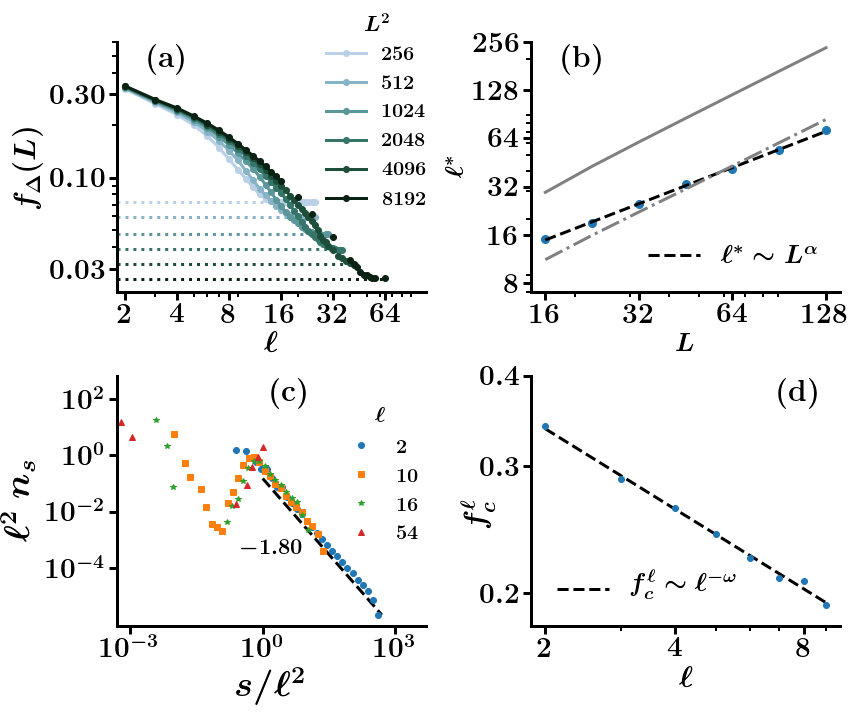

In [115]:
_sizes = [256, 512, 1024, 2048, 4096, 8192]
colormap = sns.cubehelix_palette(
    len(_sizes), start=2, rot=0.3, light=0.8, dark=0.1
)

ncols = 2
nrows = 2
fig, axes = plt.subplots(figsize=(6*ncols,5*nrows), ncols=ncols, nrows=nrows)

for ax in axes.flatten():
    ax.tick_params(which='minor', length=5)
    ax.tick_params(which='major', length=8)

ax = axes[0,0]
ax.text(0.1, 0.9, letters[0], transform=ax.transAxes, fontsize=30)
ax.set_xscale('log')
xmin = 1.8
ax.set_xlim(xmin, 110)
ax.set_xticks([2, 4, 8, 16, 32, 64])
ax.get_xaxis().set_minor_formatter(mpl.ticker.NullFormatter())
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.set_yscale('log')
ax.set_ylim(0.022, 0.6)
ax.set_yticks([0.03, 0.1, 0.3])
ax.get_yaxis().set_minor_formatter(mpl.ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())


ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$f_{\Delta}(L)$')
for i, size in enumerate(_sizes): 
    ax.plot(l_values, rc_values[size][1:], 'o-', 
            label=r'${{{}}}$'.format(size), color=colormap[i]
    )
    last_no_nan = np.argwhere(~np.isnan(rc_values[size]))[-1][0]
    ax.plot([xmin, l_values[last_no_nan]], [rc_values[size][0]]*2, linestyle=':', color=colormap[i])


legend = ax.legend(loc=(0.65, 0.3), fontsize=20, frameon=False)
legend.set_title(r'$L^2$', prop={'size':22})
    
###############################    
    
ax = axes[0,1]
ax.text(0.1, 0.9, letters[1], transform=ax.transAxes, fontsize=30)
X = np.sqrt(list(l_cutoff.keys()))
Y = np.array(list(l_cutoff.values()))
ax.set_xlabel(r'$L$', fontsize=26)
ax.set_ylabel(r'$\ell^*$', fontsize=26)
ax.set_xscale('log')
ax.set_yscale('log')
ax.plot(X, Y, 'o', markersize=8)
Y_pred, slope, y_err = getLinearReg(X, Y)
print('alpha = {:.3f}+-{:.3f}'.format(slope, y_err))
label = r'$\ell^* \sim L^{\alpha}$'
ax.plot(X, Y_pred, '--', color='k', label=label)

_N_values = [256, 512, 1024, 2048, 4096, 8192, 16384]#, 32768, 65536]
X = np.sqrt(_N_values)
diameters = np.zeros(len(X))
meanls = np.zeros(len(X))
max_diameters = np.zeros(len(X))
max_meanls = np.zeros(len(X))
net_dir = '../networks/DT'
for i, N in enumerate(_N_values):
    diameters_file = os.path.join(net_dir, 'diameters_N{}.txt'.format(N))
    d_values = np.loadtxt(diameters_file)
    diameters[i] = d_values.mean()
    meanls_file = os.path.join(net_dir, 'meanl_N{}.txt'.format(N))
    meanl = np.loadtxt(meanls_file)
    meanls[i] = meanl.mean()
    
    nseeds = 10000
    base_net_name, base_net_name_size = get_base_network_name(net_type, N, param)
    full_net_dir = os.path.join(net_dir, base_net_name, base_net_name_size)
    rc_props_output_file = os.path.join(full_net_dir, 'rc_properties_nSeeds{:d}.csv'.format(nseeds))
    rc_df = pd.read_csv(rc_props_output_file)
    max_diameters[i] = rc_df.D.mean()
    max_meanls[i] = rc_df.meanl.mean()
linestyles = ['-.', '-']
for i, Y in enumerate([max_meanls, max_diameters]):
    Y_pred, slope, y_err = getLinearReg(X[-5:], Y[-5:])    
    c = Y[0] / X[0]**slope
    #text = r'${{{:.3f}}}\pm{{{:.3f}}}$'.format(slope, y_err)
    print('diameter = {:.3f}+-{:.3f}'.format(slope, y_err))
    #ax.plot(X, Y_pred, linestyles[i], color='grey')
    ax.plot(X, Y, linestyles[i], color='grey')


ax.set_xticks([16, 32, 64, 128])
ax.get_xaxis().set_minor_formatter(mpl.ticker.NullFormatter())
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

ax.set_ylim(7, 256)
ax.set_yticks([8, 16, 32, 64, 128, 256])
#ax.set_ylim(15, 100)
#ax.set_yticks([16, 32, 64])

ax.get_yaxis().set_minor_formatter(mpl.ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

ax.legend(loc='lower right', frameon=False)

#############################################################################

ax = axes[1, 0]
ax.text(0.5, 0.9, letters[2], transform=ax.transAxes, fontsize=30)
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xticks([0.001, 1, 1000])
ax.set_yticks([1e-4, 1e-2, 1, 1e2])

ax.set_xlabel(r'$s/\ell^2$', fontsize=36)
ax.set_ylabel(r'$\ell^2\;n_s$', fontsize=36)    

ax.set_xlim(5e-4, 5e3)

X = np.logspace(0., 2.7)
a = -1.8
c = 0.15
Y = powerlaw(X, a, c)
ax.plot(X, Y, '--', color='k')
ax.text(0.4, 0.3, r'${{{:.2f}}}$'.format(a), transform=ax.transAxes, fontsize=22)

N = 8192

markers = ['o', 's', '*', '^', '<', '>']
for i, attack in enumerate(attacks):
    comp_sizes = all_comp_sizes[attack][N]
    X, Y = get_histo(comp_sizes, nbins=30)
    
    X = X / cutoff_values[i]**2
    Y = Y * cutoff_values[i]**2

    ax.plot(
        X, Y, marker=markers[i], linestyle='', 
        #color=colormap[i], 
        label=r'${{{}}}$'.format(cutoff_values[i])
    )
    
legend = ax.legend(loc=(0.7, 0.3), fontsize=20, frameon=False)
legend.set_title(r'$\ell$', prop={'size':22})

#############################################################################


_l_values = []
mean_fc_values = []
for l in range(2, 10):
    attack = 'BtwU_cutoff%d' % l
    if attack in fc_values:
        mean_fc, std_fc = fc_values[attack]
        
        _l_values.append(l)
        mean_fc_values.append(mean_fc)

ax = axes[1,1]
ax.tick_params(which='minor', length=5)
ax.tick_params(which='major', length=8)
ax.set_ylabel(r'$f_c^{\ell}$')
ax.set_xlabel(r'$\ell$')
ax.set_xscale('log')
ax.set_yscale('log')

X, Y = _l_values, mean_fc_values

Y_pred, slope, y_err = getLinearReg(X, Y)
c = Y[0] / X[0]**slope
#label = r'${{{:.2f}}}\pm{{{:.2f}}}$'.format(slope, y_err)
print('omega = {:.3f}+-{:.3f}'.format(slope, y_err))
label = r'$f_c^{\ell} \sim \ell^{-\omega}$'
ax.plot(X, Y_pred, '--', color='k', label=label)
ax.plot(X, Y, 'o')
ax.text(0.8, 0.9, letters[3], transform=ax.transAxes, fontsize=30)

#ax.set_xlim(12, 128)
ax.set_xticks([2, 4, 8])
ax.get_xaxis().set_minor_formatter(mpl.ticker.NullFormatter())
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

ax.set_ylim(0.18, 0.4)
ax.set_yticks([0.2, 0.3, 0.4])
ax.get_yaxis().set_minor_formatter(mpl.ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

ax.yaxis.set_label_coords(-0.1, 0.45)
ax.legend(frameon=False, loc=(0.05, 0.05))


#################################################    
sns.despine()
plt.tight_layout()
fig_name = os.path.join(fig_dir, 'PRL_Fig3')
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')

plt.tight_layout()
plt.show()

### Figura 4

Dimensión fractal

In [4]:
attack = 'BtwU'

sizes = np.array([256, 512, 1024, 2048, 4096, 8192, 16384])
all_mean_values = []
all_std_values = []
fluctuations = {}
for i, N in enumerate(sizes):
    delta_values = load_delta(net_type, N, param, attack)
    delta_values[:,2] = delta_values[:,2]*N
    mean_values = delta_values.mean(axis=0)
    std_values = delta_values.std(axis=0)
    
    all_mean_values.append(mean_values)
    all_std_values.append(std_values)
    
    fluctuations[N] = delta_values - mean_values
    
all_mean_values = np.array(all_mean_values)
all_std_values = np.array(all_std_values)


rc_values = all_mean_values[:,0]
delta_values = all_mean_values[:,1]

In [6]:
network = 'DT'
attack = 'BtwU'
L = 256
N = L*L
size = N
param = 'param'
seed = 90

l_values = np.array([2**i for i in range(1, int(np.log2(L))+1)])
box_count_dict = {}
rho_values_dict = {}
for i, connected in enumerate([True, False]):
    
    g, max_pos, delta_max = load_delta_data(network, size, param, attack, seed)
    position = g.vs['position']
    attack_order = g['attack_order']
    
    h = g.copy()
    h.delete_vertices(attack_order[max_pos+1:])
    gcc = h.components(mode='WEAK').giant()
    
    if connected:
        indices = gcc.vs['oi']
    else:
        indices = attack_order[:max_pos+1]
    
    print('Computing d_B')
    box_count_dict[connected] = get_box_count(position, indices)
    
    print('Computing d_f')
    rho_values = get_cluster_densities(position, indices, l_values, seeds=500)
    rho_values_dict[connected] = [rho_values, l_values]

Computing d_B
Computing d_f
Computing d_B
Computing d_f


lambda = 0.579+-0.007$


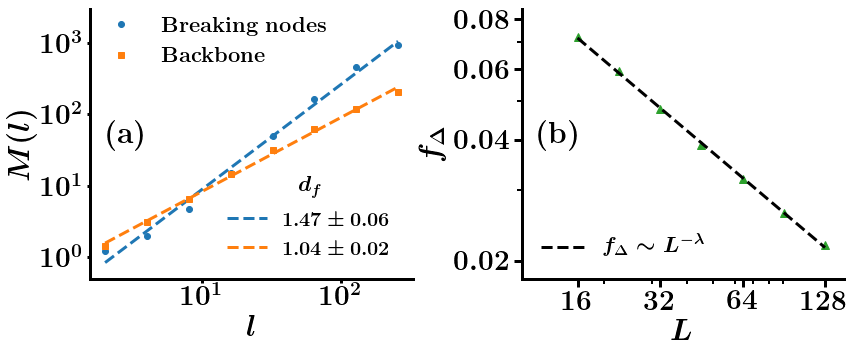

In [12]:
marker_labels = [r'$\mathrm{Breaking\;nodes}$', r'$\mathrm{Backbone}$']

ncols = 2
nrows = 1
fig, axes = plt.subplots(figsize=(6*ncols,5*nrows), ncols=ncols, nrows=nrows)   

X = np.sqrt(sizes)

ax = axes[1]
ax.text(0.05, 0.5, letters[1], transform=ax.transAxes, fontsize=30)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(10, 150)
ax.set_xticks([16, 32, 64, 128])
ax.get_xaxis().set_minor_formatter(mpl.ticker.NullFormatter())
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.tick_params(which='minor', length=5)
ax.tick_params(which='major', length=8)
ax.set_xlabel(r'$L$')

ax.set_ylim([0.018, 0.085])
ax.set_yticks([0.02, 0.04, 0.06, 0.08])
ax.get_yaxis().set_minor_formatter(mpl.ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

ax.set_ylabel(r'$f_{\Delta}$')
Y = all_mean_values[:,0]
Y_pred, slope, y_err = getLinearReg(X, Y)
ax.plot(X, Y, '^', color='C2', markersize=8)
print('lambda = {:.3f}+-{:.3f}$'.format(-slope, y_err))
#label = r'$1/\lambda={{{:.2f}}}\pm{{{:.2f}}}$'.format(-slope, y_err)
label = r'$f_{\Delta} \sim L^{-\lambda}$'
ax.plot(X, Y_pred, '--', color='k', label=label)
ax.legend(fontsize=22, loc='lower left', frameon=False)
    
##############################################

ax = axes[0]
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([0.5, 3000])
ax.set_yticks([1, 1e1, 1e2, 1e3])
ax.text(0.05, 0.5, letters[0], transform=ax.transAxes, fontsize=30)
ax.set_xlabel(r'$l$')
ax.set_ylabel(r'$M(l)$')
markers = ['o', 's']
for i, connected in enumerate([False, True]):
    
    rho_values, l_values = rho_values_dict[connected]
    X = l_values
    Y = [rho*l**2 for (rho, l) in zip(rho_values, l_values)]
    Y_pred, slope, y_err = getLinearReg(X, Y)
    
    ax.plot(X, Y, markers[i], color=f'C{i}', label=marker_labels[i])
    label = r'${{{:.2f}}}\pm{{{:.2f}}}$'.format(slope, y_err)
    ax.plot(X, Y_pred, '--', color=f'C{i}', label=label)
    
handles, labels = ax.get_legend_handles_labels()
order = [1, 3]
legend1 = ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
          fontsize=20, loc=(0.4, 0.05), frameon=False)
legend1.set_title(r'$d_f$', prop={'size':22})

ax.add_artist(legend1)
order = [0, 2]
ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
          fontsize=22, loc=(0.0, 0.75), frameon=False)

sns.despine()
plt.tight_layout()
fig_name = os.path.join(fig_dir, 'PRL_Fig4')
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')

plt.show()

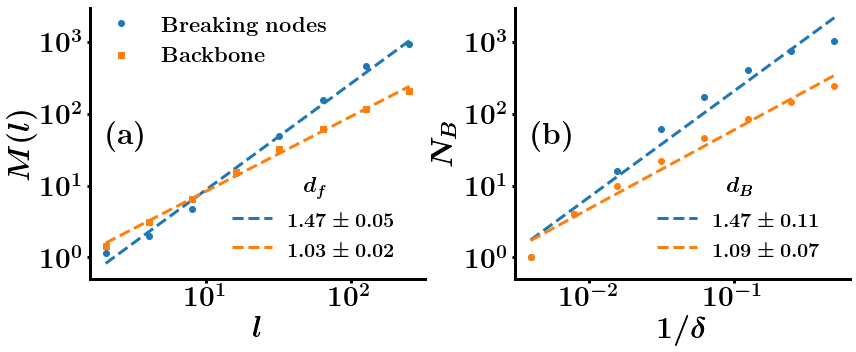

In [37]:
marker_labels = [r'$\mathrm{Breaking\;nodes}$', r'$\mathrm{Backbone}$']

ncols = 2
nrows = 1
fig, axes = plt.subplots(figsize=(6*ncols,5*nrows), ncols=ncols, nrows=nrows)

for ax in axes:
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim([0.5, 3000])
    ax.set_yticks([1, 1e1, 1e2, 1e3])
    
ax = axes[1]
ax.text(0.05, 0.5, letters[1], transform=ax.transAxes, fontsize=30)
ax.set_xlabel(r'$1/\delta$')
ax.set_ylabel(r'$N_B$')

for i, connected in enumerate([False, True]):
    
    box_count_values, l_values = box_count_dict[connected]
    X = 1/np.array(l_values)
    Y_pred, slope, y_err = getLinearReg(X, box_count_values)
    
    ax.plot(X, box_count_values, 'o', color=f'C{i}')
    label = r'${{{:.2f}}}\pm{{{:.2f}}}$'.format(slope, y_err)
    ax.plot(X, Y_pred, '--', color=f'C{i}', label=label)

legend = ax.legend(loc=(0.4, 0.05), fontsize=20, frameon=False)
legend.set_title(r'$d_B$', prop={'size':22})

##############################################

ax = axes[0]
ax.text(0.05, 0.5, letters[0], transform=ax.transAxes, fontsize=30)
ax.set_xlabel(r'$l$')
ax.set_ylabel(r'$M(l)$')
markers = ['o', 's']
for i, connected in enumerate([False, True]):
    
    rho_values, l_values = rho_values_dict[connected]
    X = l_values
    Y = [rho*l**2 for (rho, l) in zip(rho_values, l_values)]
    Y_pred, slope, y_err = getLinearReg(X, Y)
    
    ax.plot(X, Y, markers[i], color=f'C{i}', label=marker_labels[i])
    label = r'${{{:.2f}}}\pm{{{:.2f}}}$'.format(slope, y_err)
    ax.plot(X, Y_pred, '--', color=f'C{i}', label=label)
    
handles, labels = ax.get_legend_handles_labels()
order = [1, 3]
legend1 = ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
          fontsize=20, loc=(0.4, 0.05), frameon=False)
legend1.set_title(r'$d_f$', prop={'size':22})

ax.add_artist(legend1)
order = [0, 2]
ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
          fontsize=22, loc=(0.0, 0.75), frameon=False)

sns.despine()
plt.tight_layout()
fig_name = os.path.join(fig_dir, 'PRL_Fig4')
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')

plt.show()

In [ ]:
attack = 'BtwU'
sizes = [1024, 2048, 4096, 8192, 16384]
gcc = True

f_values_dict = {
    16384: ["0.02202", "0.02985", "0.02692"],
    8192: ["0.02633", "0.03650", "0.03198"],
    4096: ["0.03188", "0.04663", "0.03882"],
    2048: ["0.03875", "0.05469", "0.04834"],
    1024: ["0.04775", "0.06836", "0.05859"]
}

all_comp_sizes = {}
nseeds_values = {}

for N in sizes:
    f_value = f_values_dict[N][0]
    
    net_dir_name = '../networks/DT/DT_param'.format(param)
    base_net_name = 'DT_param_N{}'.format(N)
    base_net_dir_name = os.path.join(net_dir_name, base_net_name)
    if gcc:
        comp_sizes_file = 'comp_sizes_gcc_{}_f{}.txt'.format(attack, f_value)
        seeds_file = 'comp_sizes_gcc_{}_f{}_seeds.txt'.format(attack, f_value)
    else:
        comp_sizes_file = 'comp_sizes_{}_f{}.txt'.format(attack, f_value)
        seeds_file = 'comp_sizes_{}_f{}_seeds.txt'.format(attack, f_value)
    full_comp_sizes_file = os.path.join(base_net_dir_name, comp_sizes_file)
    full_seeds_file = os.path.join(base_net_dir_name, seeds_file)
    comp_sizes = np.loadtxt(full_comp_sizes_file, dtype=int)
    nseeds = len(np.loadtxt(full_seeds_file, dtype=int))

    nseeds_values[N] = nseeds
    all_comp_sizes[N] = comp_sizes

dfs = {}
for N in sizes:
    try:
        dfs[N] = load_dataframe(net_type, N, param, attack, min_nseeds=100)
    except FileNotFoundError:
        continue
        
N_values = np.sort(list(dfs.keys()))
L_values = np.sqrt(N_values)

colormap = sns.cubehelix_palette(
    len(L_values), start=2, rot=0.3, light=0.8, dark=0.1
)

insets = []

ncols = 2
nrows = 2
fig, axes = plt.subplots(figsize=(6*ncols, 5*nrows), ncols=ncols, nrows=nrows)
    

    
ax = axes[0,0]
ax.set_xlim(0, 0.2)
ax.set_xlabel(r'$f$')
ax.set_ylabel(r'$S_1$')


bbox_to_anchor = (.58, .4, .51, .6)
axins = inset_axes(ax, width="100%", height="100%",
        bbox_to_anchor=bbox_to_anchor,
        bbox_transform=ax.transAxes)
insets.append(axins)
axins.patch.set_alpha(0.)
axins.set_xlim(0, 1)
axins.set_xticks([0, 1])
axins.set_yticks([0, 1])
axins.set_ylabel(r'$S_1 L^{\beta/\nu}$', fontsize=26)
axins.set_xlabel(r'$f L^{1/\nu}$', fontsize=26)
axins.xaxis.set_label_coords(0.5, -0.1)
axins.yaxis.set_label_coords(-0.1, 0.5)
axins.tick_params(axis='both', which='major', labelsize=22)

#######################################

ax = axes[0,1]
ax.set_xlim(0, 0.2)
ax.set_xlabel(r'$f$')
ax.set_ylabel(r'$\langle s\rangle$')


bbox_to_anchor = (.58, .4, .51, .6)
axins = inset_axes(ax, width="100%", height="100%",
        bbox_to_anchor=bbox_to_anchor,
        bbox_transform=ax.transAxes)
insets.append(axins)
axins.patch.set_alpha(0.)
axins.set_xlim(0, 1)
axins.set_xticks([0, 1])
axins.set_yticks([0, 0.2])
axins.set_ylabel(r'$\langle s\rangle L^{-\gamma/\nu}$', fontsize=26)
axins.set_xlabel(r'$f L^{1/\nu}$', fontsize=26)
axins.xaxis.set_label_coords(0.5, -0.1)
axins.yaxis.set_label_coords(-0.2, 0.5)
axins.tick_params(axis='both', which='major', labelsize=22)

ax = axes[1,0]
ax.set_xlim(0, 0.2)
ax.set_xlabel(r'$f$')
ax.set_ylabel(r'$S_2 L^2$')


bbox_to_anchor = (.58, .4, .51, .6)
axins = inset_axes(ax, width="100%", height="100%",
        bbox_to_anchor=bbox_to_anchor,
        bbox_transform=ax.transAxes)
insets.append(axins)
axins.patch.set_alpha(0.)
axins.set_xlim(0, 1)
axins.set_xticks([0, 1])
axins.set_yticks([0, 0.2])
axins.set_ylabel(r'$S_2 L^{-\gamma/\nu}$', fontsize=26)
axins.set_xlabel(r'$f L^{1/\nu}$', fontsize=26)
axins.xaxis.set_label_coords(0.5, -0.1)
axins.yaxis.set_label_coords(-0.2, 0.5)
axins.tick_params(axis='both', which='major', labelsize=22)


for i, N in enumerate(N_values):
    
    df = dfs[N]
    L = np.sqrt(N)

    ax = axes[0,0]
    ax.text(0.9, 0.85, letters[0], transform=ax.transAxes, fontsize=30)
    ax.plot(df.f, df.Sgcc, linestyle='', marker=markers[i], markersize=3,
            label=r'${{{}}}$'.format(N), color=colormap[i])
    
    ax = insets[0]
    one_over_nu = 0.57
    nu = 1 / one_over_nu
    beta = 0
    beta_over_nu = beta / nu
    ax.plot(df.f*L**one_over_nu, df.Sgcc*N**(beta_over_nu), linestyle='', marker=markers[i], markersize=3,
        label=r'${{{}}}$'.format(N), color=colormap[i])
    
    
    ax = axes[0,1]
    ax.text(0.9, 0.85, letters[1], transform=ax.transAxes, fontsize=30)
    ax.plot(
        df.f, df.meanS, linestyle='', marker=markers[i], markersize=3, color=colormap[i]
    )
    ax = insets[1]
    one_over_nu = 0.57
    nu = 1 / one_over_nu
    gamma_over_nu = 2.05
    gamma = gamma_over_nu * nu
    ax.plot(
        df.f*L**one_over_nu, df.meanS*L**(-gamma_over_nu), linestyle='', 
        marker=markers[i], markersize=3, color=colormap[i]
    )

    ax = axes[1,0]
    ax.text(0.9, 0.85, letters[2], transform=ax.transAxes, fontsize=30)
    ax.plot(
        df.f, df.Nsec, linestyle='', marker=markers[i], markersize=3, color=colormap[i]
    )
    ax = insets[2]
    one_over_nu = 0.57
    nu = 1 / one_over_nu
    beta = -0.06
    beta_over_nu = beta / nu
    ax.plot(
        df.f*L**one_over_nu, df.Nsec*L**(beta_over_nu-2), linestyle='', 
        marker=markers[i], markersize=3, color=colormap[i]
    )
    

####################################

ax = axes[1,1]
ax.tick_params(which='minor', length=5)
ax.tick_params(which='major', length=8)
ax.set_xlabel(r'$s/L^2$', fontsize=36)
ax.set_ylabel(r'$n_s$', fontsize=36)    
ax.text(0.7, 0.85, letters[3], transform=ax.transAxes, fontsize=30)

for i, N in enumerate(sizes):

    nseeds = nseeds_values[N]
    comp_sizes = all_comp_sizes[N]
    nbins = 50   
    hist, bin_edges = np.histogram(comp_sizes, bins=nbins, density=False)
    
    X = (bin_edges[1:] + bin_edges[:-1]) / 2
    Y = hist

    X = X / N
    Y = Y / nseeds
    ax.plot(
        X, Y, marker='o', linestyle='', label=r'${{{}}}$'.format(N), color=colormap[i]
    )

legend = ax.legend(loc=(0.05, 0.3), fontsize=22, frameon=False)
legend.set_title(r'$L^2$', prop={'size':22})

sns.despine()
plt.tight_layout()
fig_name = os.path.join(fig_dir, 'PRL_Fig1')
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')
plt.show()